In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sps
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(0)

## **Instantiate a GLM class**

Here are inputs that you can provide when you instantiate the `GLM` class. If not provided, it will be set to the respective defaults

- `distr`: str, `'poisson'` or `'normal'` or `'binomial'` or `'multinomial'`
    default: `'poisson'`
- `alpha`: float, the weighting between L1 and L2 norm, default: 0.5
- `reg_lambda`: array, array of regularized parameters,
    default: `np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1))`
- `learning_rate`: float, learning rate for gradient descent,
    default: 1e-4
- `max_iter`: int, maximum iteration for the model, default: 100

In [3]:
# import GLM model
from pyglmnet import GLM

# create regularize parameters for model
reg_lambda = np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1))
model = GLM(distr='poisson', verbose=False, alpha=0.05, 
            max_iter=1000, learning_rate=1e-4, 
            reg_lambda=reg_lambda)

## **Simulate a dataset**
The ```GLM``` class has a very useful method called ```simulate()```. 

Since a canonical link function is already specified by the distribution parameters, or provided by the user, ```simulate()``` requires only the independent variables ```X``` and the coefficients ```beta0``` and ```beta```

In [4]:
# Dataset size
N = 10000
p = 100

# Coefficients

# baseline term
beta0 = np.random.normal(0.0, 1.0, 1)
# sparse model terms
beta = sps.rand(p,1,0.1)
beta = np.array(beta.todense())

# Training data
Xr = np.random.normal(0.0, 1.0, [N,p])
yr = model.simulate(beta0, beta, Xr)

# Test data
Xt = np.random.normal(0.0, 1.0, [N,p])
yt = model.simulate(beta0, beta, Xt)

## **Fit the model**

Fitting the model is accomplished by a single ```GLM``` method called ```fit()```. You can provide data and output pair `(X, y)` i.e.

```python
model.fit(X, y)
```

In [5]:
# Fit model to training data
scaler = StandardScaler().fit(Xr)
model.fit(scaler.transform(Xr),yr);

### Visualize the fit coefficients

The estimated coefficients are stored in an instance variable called `.fit_` which is a list of dictionaries. Each dictionary corresponds to a particular `reg_lambda`

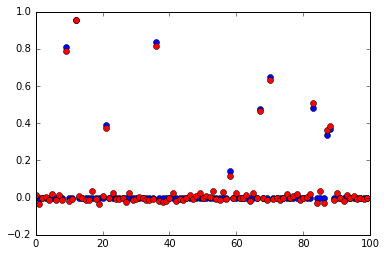

In [6]:
# Visualize estimated coefficients
model.fit_
fit_param = model.fit_[-2]
plt.plot(beta[:], 'bo')
plt.hold(True)
plt.plot(fit_param['beta'][:], 'ro')
plt.show()

### Slicing the model object

Although the model is fit to all values of `reg_lambda` specified by a regularization path, often we are only interested in further analysis for a particular value of `reg_lambda`. We can easily do this by slicing the object. 

For instance `model[0]` returns an object identical to `model` but with `.fit_` as a dictionary corresponding to the estimated coefficients for `reg_lambda[0]`. 

In [7]:
m = model[-1]
this_model_param = m.fit_
print this_model_param['beta'][:5]
print this_model_param['beta0']

[[ 0.01569375]
 [-0.03319941]
 [ 0.00102511]
 [ 0.00139603]
 [-0.01391651]]
[ 1.73995812]


### Make predictions based on fit model
The ```predict()``` method takes two parameters: a numpy 2d array of independent variables and a dictionary of fit parameters. It returns a vector of predicted targets.



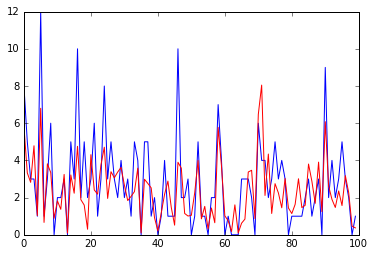

In [8]:
# Predict targets from test set
yrhat = m.predict(scaler.transform(Xr))
ythat = m.predict(scaler.transform(Xt))

plt.plot(yt[:100])
plt.hold(True)
plt.plot(ythat[:100], 'r')
plt.show()

## **Goodness of fit**

The ```GLM``` class provides two methods for evaluating goodness of fit: ```deviance()``` and ```pseudo_R2()```. Both of them require the true targets and the predicted targets as inputs. ```pseudo_R2()``` additionally requires a null model, which is typically the mean of the target variables in the training set.

In [9]:
# Compute model deviance
Dr = m.deviance(yr, yrhat)
Dt = m.deviance(yt, ythat)
print Dr, Dt

10459.8852543 10926.8204694


In [10]:
# Compute pseudo-R2s
R2r = m.pseudo_R2(yr, yrhat, np.mean(yr))
R2t = m.pseudo_R2(yt, ythat, np.mean(yr))
print R2r, R2t

0.499274174475 0.479238433821


In [11]:
import scikits.bootstrap as boot

In [12]:
# Get bootstrap CIs for pseudo-R2s
ci = boot.ci((yr, yrhat, np.mean(yr)*np.ones(np.shape(yr)[0])), statfunction=model.pseudo_R2, n_samples=100, alpha=0.05)
print ci

[ 0.48887523  0.50714237]


/home/pavan/anaconda2/lib/python2.7/site-packages/scikits/bootstrap/bootstrap.py:202: InstabilityWarning: Some values used top 10 low/high samples; results may be unstable.
  warnings.warn("Some values used top 10 low/high samples; results may be unstable.", InstabilityWarning)


### Optionally specify your own exponential family distribution
If you wish to use your own distribution other than the ones provided, you need to provide three functions. 
* A nonlinearity (inverse link function), given by the method ```qu()```.
* A corresponding log-likelihood, given by the method ```logL()```.
* A corresponding gradient of the $\mathcal{l}_2$ loss given by method ```grad_L2loss()```.

Here is a example that gives each of those functions for the Poisson GLM implementation in ```pyglmnet```.

In [13]:
# Example nonlinearity (aka inverse link function)
def qu(z):
    eps = 0.1
    q = np.log(1+eps+np.exp(z))
    return q
model.qu = qu

# Example log-likelihood
def logL(beta0, beta, x, y):
    l = model.lmb(beta0, beta, x)
    logL = np.sum(y*np.log(l) - l)
    return logL
model.logL = logL

# Example gradient term
def grad_L2loss(beta0, beta, alpha, reg_lambda, x, y):
    z = beta0 + np.dot(x, beta)
    q = model.qu(z)
    s = expit(z)
    grad_beta0 = np.sum(s) - np.sum(y*s/q)
    grad_beta = np.transpose(np.dot(np.transpose(s), x) - np.dot(np.transpose(y*s/q), x)) \
                + reg_lambda*(1-alpha)*beta
    return grad_beta0, grad_beta
model.grad_L2loss = grad_L2loss

## **Multinomial example**

In [14]:
from sklearn.datasets import make_classification
from pyglmnet import GLM

In [15]:
X, y = make_classification(n_samples=10000, n_classes=5, 
                           n_informative=100, n_features=100, n_redundant=0)

In [16]:
model_mn = GLM(distr='multinomial', alpha=0.01, 
               reg_lambda=np.array([0.02, 0.01]), verbose=False)
model_mn.threshold = 1e-5
model_mn.fit(X, y)
y_pred = model_mn[-1].predict(X).argmax(axis=1)
print (y_pred == y).mean()

0.4632
